# D213 - TASK 1: TIME SERIES MODELING

<a href="https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=004f2007-2ccb-48c4-8caa-ad520041017f" target="_blank"> Link to the Panopto Video </a>

https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=004f2007-2ccb-48c4-8caa-ad520041017f

-------------------------------------------------------------------------------------------------------------------------------

#### Importing Libraries:

In [1]:
#importing the needed libraries.
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) #modified Pandas options to fully display the large dataset when needed
## !!! Trying to Display a full Dataframe may cause a problem.
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime  # To manually create dates

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pylab import rcParams

import warnings # (Fulton-Datacamp)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

-------------------------------------------------------------------------------------------------------------------------------

#### Part I:  Research Question

##### A.  Describe the purpose of this data analysis by doing the following:

##### 1.  Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.

With the help of time series analysis, we can conclude patterns in data, the inferring uncertainty (confidence interval), and in the best case, forecasting the future of the company's revenue.

The patterns in time series data may include: Trends (increasing or decreasing), Seasonality (cyclic pattern) & variability (Heteroscedasticity)

while the company's executives would like to see consider a time series on revenue from the first years of operation, as part of the “churn” project Once they understand any patterns in that data, they feel confident in understanding the impact of churn in current times (WGU,2021).

A question to be asked is, can a predictive time series model highlight the patterns in revenue data in the first two years of operations, and can give the executives the confidence in inferring the impact of churn in current times?


##### 2.  Define the objectives or goals of the data analysis. Ensure that your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.

The objectives or goal of the data analysis is building and testing a predictive time series model that can highlight the patterns in revenue data in the first two years of operations and can give the executives the confidence in inferring the impact of churn in current times, and estimate the uncertainty/confidence in forecasting the company's revenue in future.

-------------------------------------------------------------------------------------------------------------------------------

#### Part II:  Method Justification

##### B.  Summarize the assumptions of a time series model including stationarity and autocorrelated data.

##### The basic  assumptions of a time series model are:

##### 1. Stationarity: 
The first assumption is that the time series is stationary.  Essentially, this means that the properties of the series don’t depend on the time when it is captured (Chatterjee, 2018)., and the series is normally distributed where the mean and variance are constant over a long period.
A white noise series and series with cyclic behavior can also be considered stationary series (Chatterjee, 2018). 

##### 2. Random shocks (a random error component): 
If shocks are present, they are assumed to be randomly distributed with a mean of 0 and a constant variance.

##### 3. Data should be univariate :
ARIMA works on a single variable. Auto-regression is all about regression with the past values (Chatterjee, 2018).

##### 4. No outliers:
Outliers may affect conclusions strongly and can be misleading.

-------------------------------------------------------------------------------------------------------------------------------

#### Part III:  Data Preparation

##### C.  Summarize the data cleaning process by doing the following:

##### 1.  Provide a line graph visualizing the realization of the time series.

In [2]:
#Reading the Data file (As received) teleco_time_series .csv
df_raw= pd.read_csv('teleco_time_series .csv')

# Convert the day column to datetime64
origin_date = pd.Timestamp('2000-01-01')  # Assumed origin date of years of operation, for lack of exact information.

df_raw.Day = pd.to_datetime(df_raw.Day-1,unit='D',origin = origin_date)

# Set day column as index
df_raw.set_index('Day', inplace=True)

# Set index frequency
df_raw.index.freq=df_raw.index.inferred_freq

# Inspect data 
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2000-01-01 to 2001-12-31
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB
None



 Figure (1) 



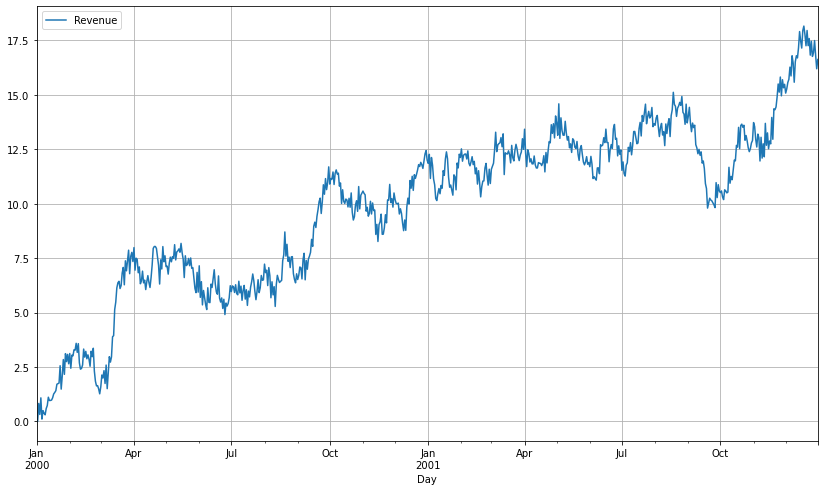

In [3]:
# Plot and show the time series on axis ax

print('\n Figure (1) \n')
fig, ax = plt.subplots(figsize = (14,8))
df_raw.plot(ax=ax)
plt.grid()
plt.show()

##### 2.  Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.

In [4]:
print('\n Length of the sequence: ',df_raw.shape[0])
print('\n Gaps in measurement: ',df_raw.isnull().all(axis=1).sum())


 Length of the sequence:  731

 Gaps in measurement:  0


* The given time series data records the daily revenue, the time step unit is Day.
* The length of the sequence is 731 records, the first record is 1 and the last is 731 with No Gaps in measurement.
* To treat it as Pandas time series, the 'Day' column was converted from int to datetime64 using pd.to_datetime() function, and the date column has been reset to index.
*  Assumed '2000-01-01' as the origin date of years of operation, for lack of exact information.

##### 3.  Evaluate the stationarity of the time series.

The Line graph shows a clear positive trend with time.
Using the augmented Dickey-Fuller test which tests for trend non-stationarity (Null hypothesis is time series is non-stationary)

In [5]:
# (Fulton-Datacamp)

adfuller_tst = adfuller(df_raw['Revenue'])
print(adfuller_tst)

# Print the test statistic and the p-value
print('\n Adfuller Statistic:', adfuller_tst[0])
print(' p-value:', adfuller_tst[1])

(-1.9246121573101853, 0.3205728150793957, 1, 729, {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}, 965.0609576707513)

 Adfuller Statistic: -1.9246121573101853
 p-value: 0.3205728150793957


To reject the Null hypothesis (that time series is non-stationary), the test statistics must be less than -2.865 (for P-value 0.05) while the test result statistics is -1.924, so the raw data is clearly non-stationary.

* Using augmented Dickey-Fuller gave enough evidence of non-stationarity, but  we can use some more data visualizations for deeper data investigation as following:


 Figure (2) 



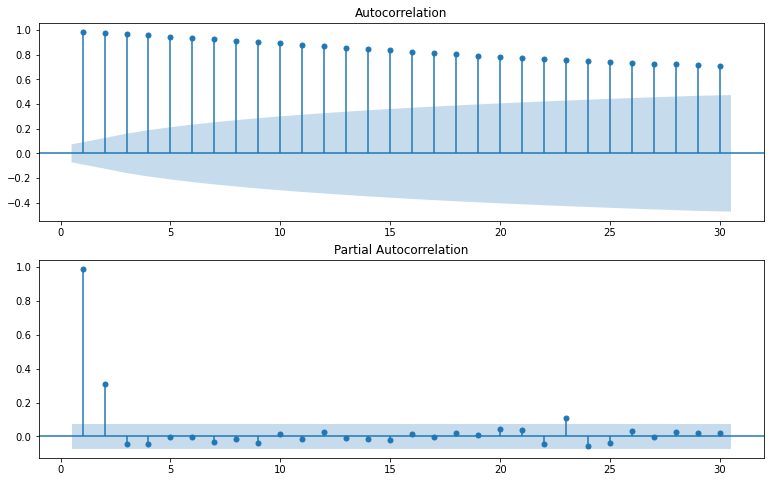

In [6]:
print('\n Figure (2) \n')
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(13,8))
# Make ACF plot
plot_acf(df_raw, lags=30, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(df_raw, lags=30, zero=False, ax=ax2)
plt.show()


 Figure (3) 



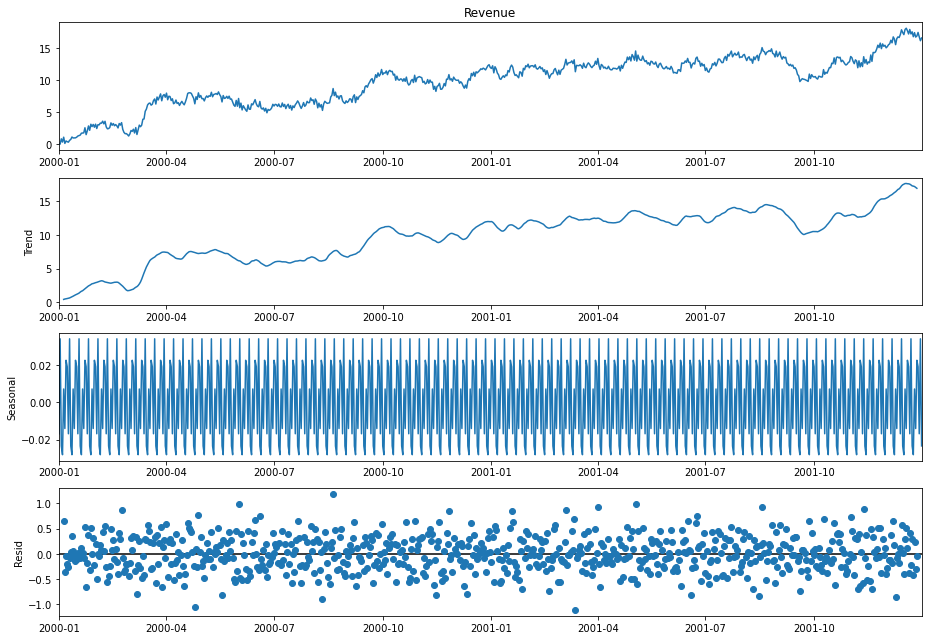

In [7]:
print('\n Figure (3) \n')
rcParams['figure.figsize'] = 13, 9
decomposition = sm.tsa.seasonal_decompose(df_raw['Revenue'],period=8) # ,period=10
fig = decomposition.plot()
plt.show()


 Figure (4) 



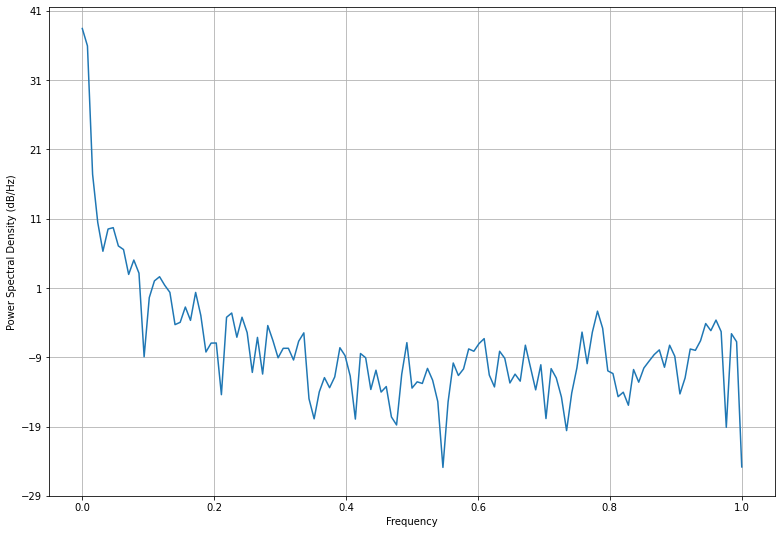

In [8]:
print('\n Figure (4) \n')
plt.psd(df_raw['Revenue']) #df_raw['Revenue']
plt.show()

##### 4.  Explain the steps used to prepare the data for analysis, including the training and test set split.

In [9]:
df_diff = df_raw.copy().diff().dropna()

In [10]:
'''Custom function: splits the data into a train and test set by a test_ratio of total period'''

def split_ts(df_input,test_ratio):
    train_period=np.int_(df_input.shape[0])-np.int_(df_input.shape[0]*test_ratio)-1
    test_period=train_period+1

    df_train = df_input.iloc[:(train_period)+1].copy()
    df_test = df_input.iloc[(test_period):].copy()
    return df_train,df_test


 Figure (5) 



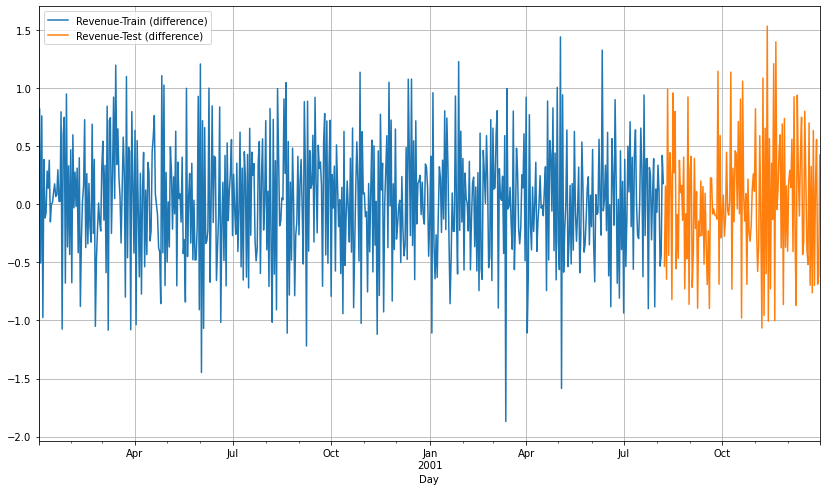

In [11]:
df_train,df_test= split_ts(df_diff,0.2)

print('\n Figure (5) \n')
# Create an axis
fig, ax = plt.subplots(figsize = (14,8))

# Plot the train and test sets on the axis ax
df_train.plot(ax=ax)
df_test.plot(ax=ax)
plt.grid()
plt.legend(['Revenue-Train (difference)','Revenue-Test (difference)'])
plt.show()

##### 5.  Provide a copy of the cleaned dataset.

In [12]:
# Saving a copy of the prepared full data set.
D213_T1_cleaned_dataset=df_diff.copy()
D213_T1_cleaned_dataset.to_csv('D213_T1_cleaned_dataset.csv', index = True)

# Saving a copy of the prepared Training data set.
D213_T1_cleaned_Training_dataset=df_train.copy()
D213_T1_cleaned_Training_dataset.to_csv('D213_T1_cleaned_Training_dataset.csv', index = True)

# Saving a copy of the prepared Test data set.
D213_T1_cleaned_Test_dataset=df_test.copy()
D213_T1_cleaned_Test_dataset.to_csv('D213_T1_cleaned_Test_dataset.csv', index = True)

-------------------------------------------------------------------------------------------------------------------------------

#### Part IV:  Model Identification and Analysis

##### D.  Analyze the time series dataset by doing the following:

##### 1.  Report the annotated findings with visualizations of your data analysis, including the following elements:

•   the presence or lack of a seasonal component

•   trends

•   auto correlation function

•   spectral density

•   the decomposed time series

•   confirmation of the lack of trends in the residuals of the decomposed series

##### 1.   the presence or lack of a seasonal component 
After taking the differences to remove seasonality, minor seasonal components can be noticed from power spectral density -Figure (8), where we can see some high-frequency components (from 0.1 cycle/day to 1 cycle/day) but at very small power spectral density values. also, the autocorrelation plot -Figure (6) shows no autocorrelation or just minor unlike the raw series before taking the differences -Figure (2).


##### 2.   trends 
-> Figure (7) the decomposed time series of differences shows no trends, and the Adfuller test results confirm that.

##### 3.   auto correlation function 
-> The autocorrelation plot -Figure (6) shows no autocorrelation or just minor.

##### 4.   spectral density 
-> Figure (8) we can see some high frecuency components (from 0.1 cycle/day to 1 cycle/day) but at very small power spectral density values(minor seasonal components).

##### 5.   the decomposed time series 
-> Figure (7), The decomposed time series of differences show no trends and confirms the lack of trends in the residuals.

##### 6.  confirmation of the lack of trends in the residuals of the decomposed series 
-> The resid-plot in Figure (7) shows the lack of trends in the residuals.


In [13]:
adfuller_tst = adfuller(df_diff['Revenue'])
print(adfuller_tst)

# Print the test statistic and the p-value
print('\n Adfuller Statistic:', adfuller_tst[0])
print(' p-value:', adfuller_tst[1])

(-44.874527193875984, 0.0, 0, 729, {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}, 965.5032159185916)

 Adfuller Statistic: -44.874527193875984
 p-value: 0.0



 Figure (6) 



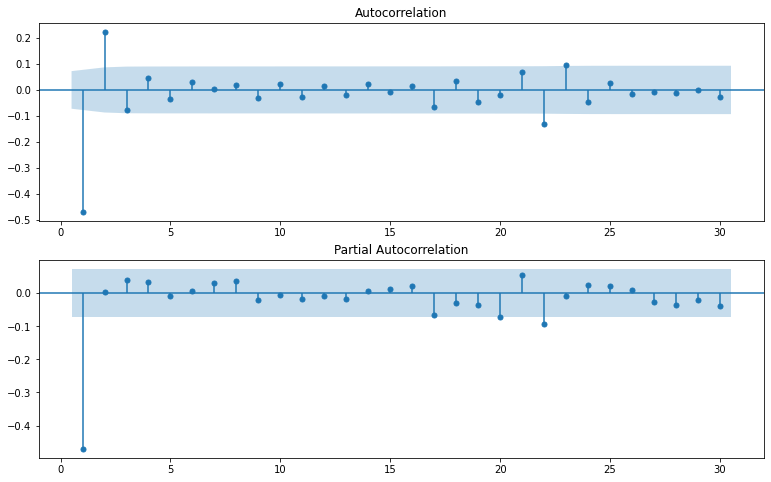

In [14]:
print('\n Figure (6) \n')
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(13,8))
# Make ACF plot
plot_acf(df_diff, lags=30, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(df_diff, lags=30, zero=False, ax=ax2)
plt.show()


 Figure (7) 



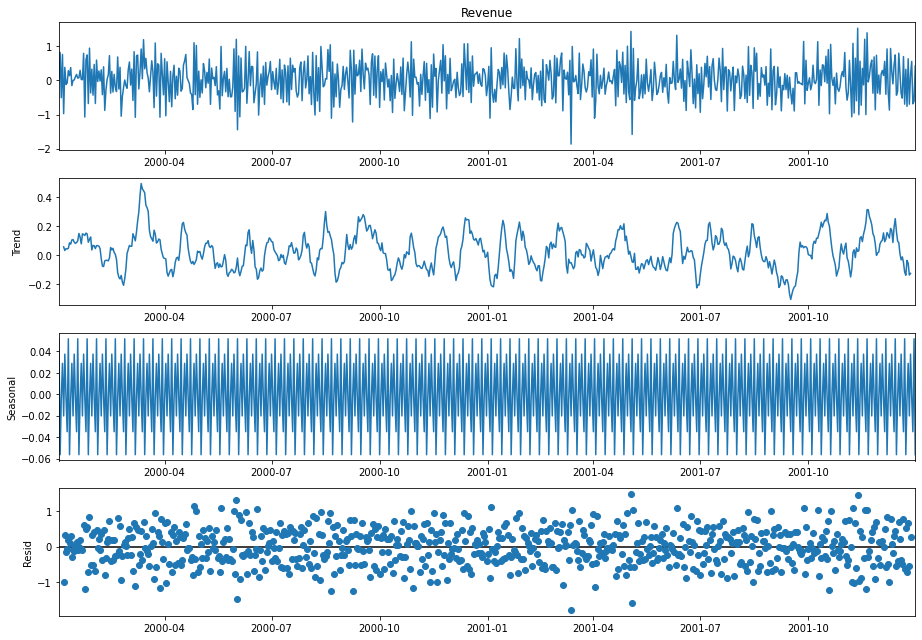

In [15]:
print('\n Figure (7) \n')
rcParams['figure.figsize'] = 13, 9
decomposition = sm.tsa.seasonal_decompose(df_diff['Revenue'],period=8) # ,period=10
fig = decomposition.plot()
plt.show()


 Figure (8) 



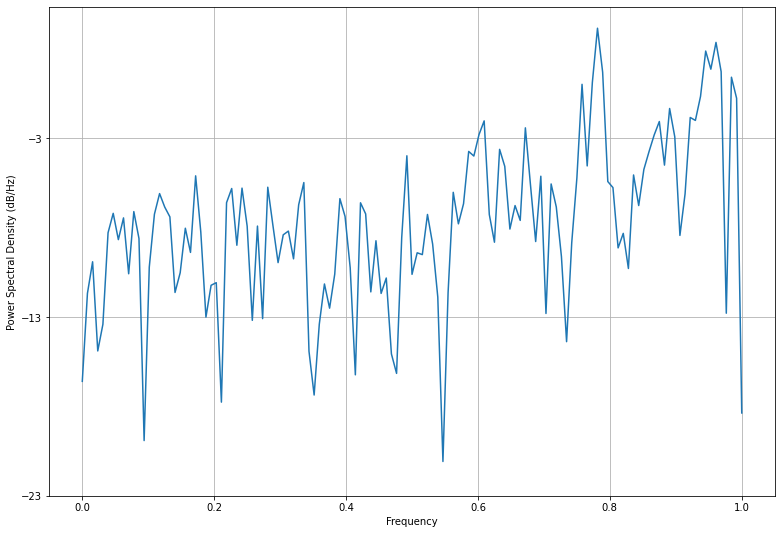

In [16]:
print('\n Figure (8) \n')
plt.psd(df_diff['Revenue'])
plt.show()

##### 2.  Identify an autoregressive integrated moving average (ARIMA) model that takes into account the observed trend and seasonality of the time series data.

In [17]:
df_train,df_test= split_ts(df_raw,0.2)

##### Identifying the model parameters using minimum Adfuller Statistic and appropriate p-value:

In [18]:
# (Fulton-Datacamp)
diff_tst_lst =[]
for i in range(0,40):
    if i== 0:
        df_tmp=df_train.copy()
    else:
        df_tmp=df_train.copy().diff(periods=i).dropna()
    adfuller_tst = adfuller(df_tmp['Revenue'])
    diff_tst_lst.append((i, adfuller_tst[0], adfuller_tst[1]))
    
adfuller_tst_optm = pd.DataFrame(diff_tst_lst, columns=['d','ADF','pval'])

In [19]:
adfuller_tst_optm.sort_values('ADF').head(10)

,d,ADF,pval
1,1,-39.653275,0.000000e+00
20,20,-7.216824,2.162271e-10
4,4,-7.139814,3.346845e-10
10,10,-7.136809,3.404281e-10
5,5,-6.953087,9.580887e-10
2,2,-6.377038,2.270375e-08
3,3,-6.314396,3.176658e-08
11,11,-6.291341,3.593008e-08
7,7,-6.132953,8.316716e-08
24,24,-5.876812,3.145417e-07


##### Identifying the model parameters using minimum AIC and BIC:

In [20]:
# (Fulton-Datacamp)

order_optm_aic_bic =[]

# Loop over p values from 0-2
for d in range(0,3):
    # Loop over p values from 0-3
    for p in range(0,4):
        # Loop over q values from 0-3
        for q in range(0,4):

            try:
                # create and fit ARMA(p,q) model
                model_optm = SARIMAX(df_train, order=(p,d,q))
                results_optm = model_optm.fit()

                # Add order and scores to list
                order_optm_aic_bic.append((p,d, q, results_optm.aic, results_optm.bic))

            except:
                order_optm_aic_bic.append((p,d, q, None, None))

# Make DataFrame of model order and AIC/BIC scores
df_order_optm = pd.DataFrame(order_optm_aic_bic, columns=['p','d','q','aic','bic'])

In [21]:
# Sort by AIC
print(df_order_optm.sort_values('aic').head())

    p  d  q         aic         bic
20  1  1  0  774.990256  783.730058
19  0  1  3  776.819482  794.299086
28  3  1  0  776.932062  794.411666
24  2  1  0  776.988595  790.098298
21  1  1  1  776.988938  790.098641


In [22]:
# Sort by BIC
print(df_order_optm.sort_values('bic').head())

    p  d  q         aic         bic
20  1  1  0  774.990256  783.730058
24  2  1  0  776.988595  790.098298
21  1  1  1  776.988938  790.098641
18  0  1  2  777.503901  790.613604
37  1  2  1  780.701869  793.806431


##### Applying best identified parameters to the ARIMA model:

In [23]:
arima = SARIMAX(df_train, order=(1,1,0))

# Fit the model
results = arima.fit()

# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  585
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -385.495
Date:                Thu, 24 Jun 2021   AIC                            774.990
Time:                        21:59:57   BIC                            783.730
Sample:                    01-01-2000   HQIC                           778.397
                         - 08-07-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.036    -12.605      0.000      -0.528      -0.386
sigma2         0.2191      0.014     15.965      0.000       0.192       0.246
Ljung-Box (L1) (Q):                   0.02   Jarque-


 Figure (9) 



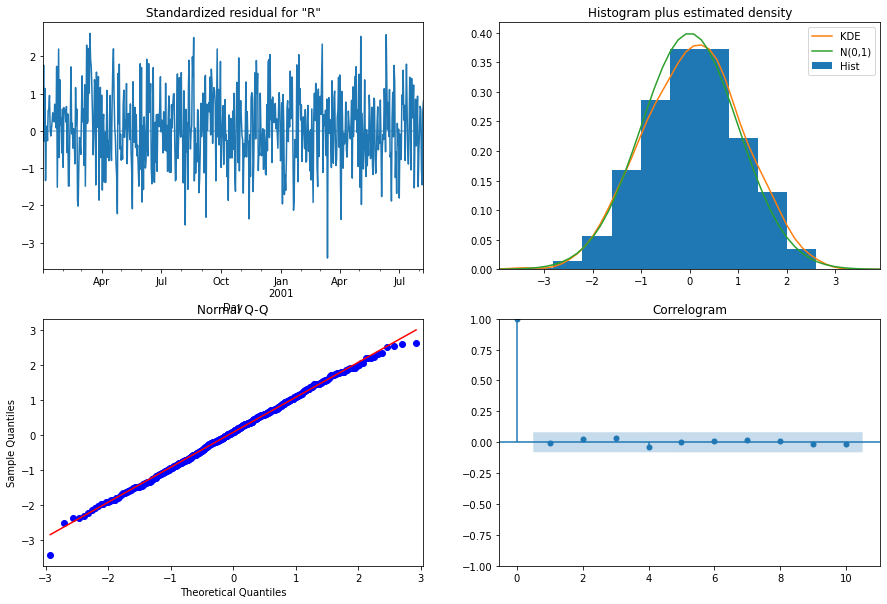

In [24]:
print('\n Figure (9) \n')
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(15,10))
plt.show()

In [25]:
# Make in-sample prediction (one-step-ahead predictions)
arima_prediction = results.get_prediction(start=-150, dynamic=False)

# forecast mean
mean_prediction = arima_prediction.predicted_mean.to_frame()

# Get confidence intervals of forecasts
prediction_CI = arima_prediction.conf_int()

# Print forecast
# print((arima_value_forecast))


 Figure (10) 



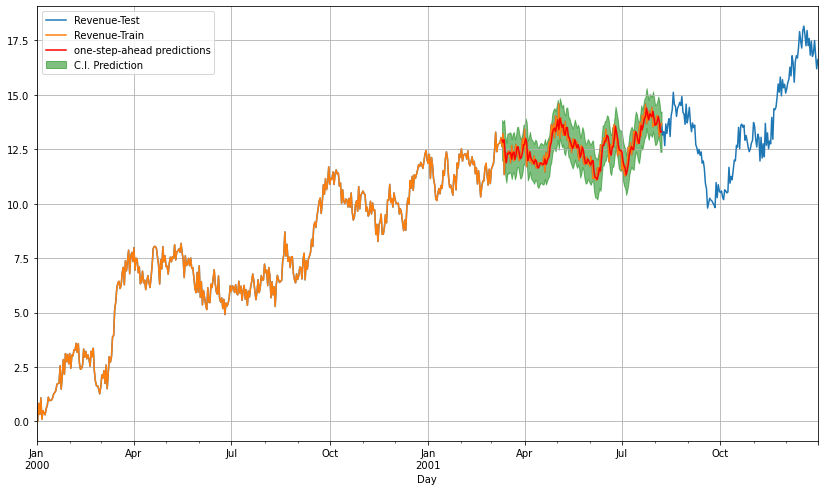

In [26]:
print('\n Figure (10) \n')

# Create an axis
fig, ax = plt.subplots(figsize = (14,8))

# Plot the train and test sets on the axis ax
df_raw.plot(ax=ax)
df_train.plot(ax=ax)
# df_test.plot(ax=ax)

# Plot prediction
plt.plot(mean_prediction,color='red',label='prediction')

# Shade uncertainty area
plt.fill_between(prediction_CI.index,prediction_CI['lower Revenue'], prediction_CI['upper Revenue'], color='g',alpha=0.5,label='C.I. Pred.')

plt.legend(['Revenue-Test','Revenue-Train','one-step-ahead predictions','C.I. Prediction'],loc='upper left')
plt.grid()
plt.show()

- Confirmation of the lack of trends in the residuals of the decomposed series :

* Prob(Q) - p-value for null hypothesis that residuals are uncorrelated = 0.9
* Prob(JB) - p-value for null hypothesis that residuals are normal = 0.4

Failed to reject both null hypothesis.

##### 3.  Perform a forecast using the derived ARIMA model.

In [27]:
#-------------------------------------------------
# Out-of-sample prediction (Out of training sample)
arima_forecast = results.get_forecast(steps=150)
# forecast mean
mean_forecast = arima_forecast.predicted_mean.to_frame()
# Get confidence intervals of forecasts
forecast_CI = arima_forecast.conf_int()

##### 4.  Provide the output and calculations of the analysis you performed.

In [28]:
display(mean_forecast.head(20))

,predicted_mean
2001-08-08,13.602625
2001-08-09,13.640176
2001-08-10,13.623022
2001-08-11,13.630859
2001-08-12,13.627279
2001-08-13,13.628914
2001-08-14,13.628167
2001-08-15,13.628508
2001-08-16,13.628352
2001-08-17,13.628424


##### 5.  Provide the code used to support the implementation of the time series model.

* Listed above

-------------------------------------------------------------------------------------------------------------------------------

#### Part V:  Data Summary and Implications

##### E.  Summarize your findings and assumptions, including the following points:

##### 1.  Discuss the results of your data analysis, including the following:

•   the selection of an ARIMA model

•   the prediction interval of the forecast

•   a justification of the forecast length

•   the model evaluation procedure and error metric

##### •   the selection of an ARIMA model:
The selection is based on using ACF and PACF to choose model order and confirmed by testing the input parameters as explained in previous sections. 

##### •   the prediction interval of the forecast.
The data has been split into train and test datasets by 80%/20% ratio 

##### •   a justification of the forecast length
The prediction interval of the forecast was selected to cover the test data range.


##### •   the model evaluation procedure and error metric
The Model evaluation achieved through different recommended tools and Diagnostic metrics such as:
- Tested inputs.
- Min AIC/BIC values.
- Model's residuals distribution (normality)
- Model's residuals ACF (no autocorrelation)
- Model's residuals are normal and uncorrelated (Prob(Q):0.90   Prob(JB):0.40)
- Visually examined both in-sample prediction and out-of-Test-sample forecast.

##### 2.  Provide an annotated visualization of the forecast of the final model compared to the test set.


 Figure (11) 



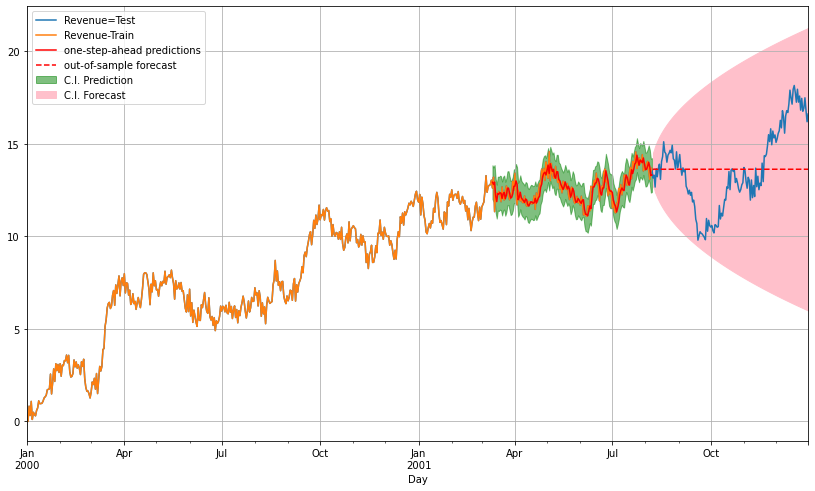

In [29]:
print('\n Figure (11) \n')

# Create an axis
fig, ax = plt.subplots(figsize = (14,8))

# Plot the train and test sets on the axis ax
df_raw.plot(ax=ax)
df_train.plot(ax=ax)
# df_test.plot(ax=ax)

# Plot prediction
plt.plot(mean_prediction,color='red',label='prediction')
plt.plot(mean_forecast,'--',color='red',label='forecast')

# Shade uncertainty area
plt.fill_between(prediction_CI.index,prediction_CI['lower Revenue'], prediction_CI['upper Revenue'], color='g',alpha=0.5,label='C.I. Pred.')
plt.fill_between(forecast_CI.index,forecast_CI['lower Revenue'], forecast_CI['upper Revenue'], color='pink',label='C.I. Forc.')

plt.legend(['Revenue=Test','Revenue-Train','one-step-ahead predictions','out-of-sample forecast','C.I. Prediction','C.I. Forecast'],loc='upper left')
plt.grid()
plt.show()

##### 3.  Recommend a course of action based on your results.

The variance of forecast residuals is relatively very high due to depending only on one preceding sample, the forecast confidence range is too broad, the forecast converged very fast to a conservative mean. means that the pattern is not very optimistic and the revenue forecast must be conservative as well.

-------------------------------------------------------------------------------------------------------------------------------

#### Part VI:  Reporting

##### F.  Create your report from part E using an industry-relevant interactive development environment (e.g., an R Markdown document, a Jupyter Notebook, etc.). Include a PDF or HTML document of your executed notebook presentation.

* D213_TASK_1.html  file submitted.

##### G.  List the web sources used to acquire data or segments of third-party code to support the application.


##### H.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

##### I.  Demonstrate professional communication in the content and presentation of your submission

<a href="https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=004f2007-2ccb-48c4-8caa-ad520041017f" target="_blank"> Link to the Panopto Video </a>

https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=004f2007-2ccb-48c4-8caa-ad520041017f

-------------------------------------------------------------------------------------------------------------------------------

### References:

* WGU. D213 Advanced Data Analytics.  (2021, June 21), TIME SERIES MODELING Data Files and Associated Dictionary Files.
https://access.wgu.edu/ASP3/aap/content/s8dj4edjf84hd8fcvn3d.zip


* Jason Brownlee. (2020) How to Identify and Remove Seasonality from Time Series Data with Python.
https://machinelearningmastery.com/time-series-seasonality-with-python/


* AnalyticsVidhya.com (2021) Statistical tests to check stationarity in Time Series – Part 1.
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/


* Subhasree Chatterjee. (2018) Time Series Analysis Using ARIMA Model In R.
https://datascienceplus.com/time-series-analysis-using-arima-model-in-r/


* James Fulton. (No date) ARIMA Models in Python (Datacamp course).
https://learn.datacamp.com/courses/arima-models-in-python


* (Datacamp Track) Time Series with Python.
https://learn.datacamp.com/skill-tracks/time-series-with-python


* statisticssolutions.com (No date) Time Series Analysis.
https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/time-series-analysis/



* Chad Fulton. (2017) SARIMAX dynamic prediction.
https://github.com/statsmodels/statsmodels/issues/4012



* General Questions/Answers from https://stackoverflow.com/


* General Questions/Answers from https://github.com


* Documentation of Python packages: pandas, matplotlib,numpy and statsmodels.